# ARIMA 로 kakao 주가 예측

In [1]:
# 라이브러리
import os
import math
import warnings
from itertools import product

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima

warnings.filterwarnings('ignore')

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [3]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12, 6

In [5]:
kakao = pd.read_csv('./data/kakao_juga_from_2010.csv', index_col='날짜', parse_dates=True)

In [6]:
# 종가만 가져오기
kakao_price = kakao[['종가']]

Text(0.5, 0, 'Close')

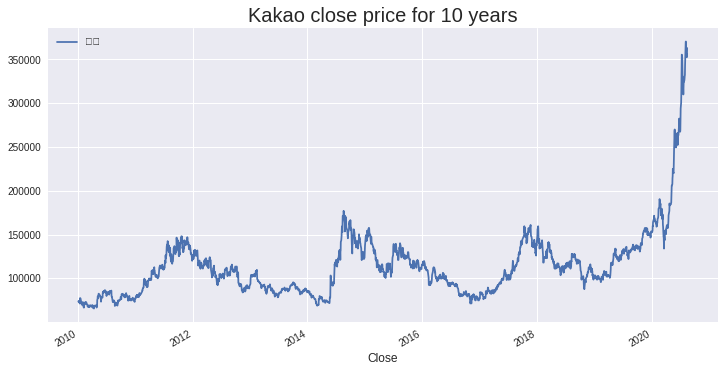

In [7]:
kakao_price.plot()
plt.title('Kakao close price for 10 years', fontsize=20)
plt.xlabel('Close',fontsize=12)

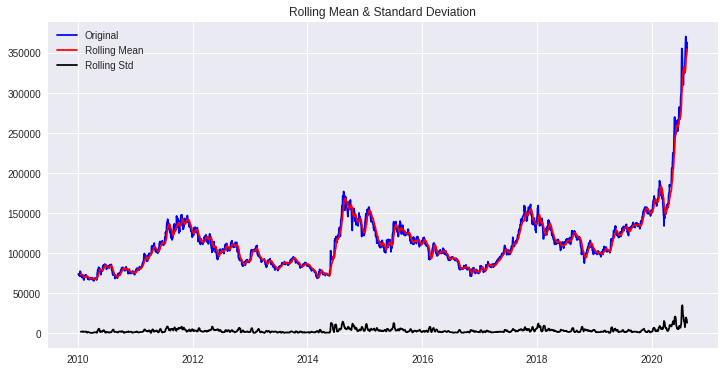

In [8]:
plot_rolling_statistics(kakao_price)

In [9]:
kakao_price.columns = ['Close']

In [10]:
decomposition = seasonal_decompose(kakao_price['Close'], freq=30)

<Figure size 864x432 with 0 Axes>

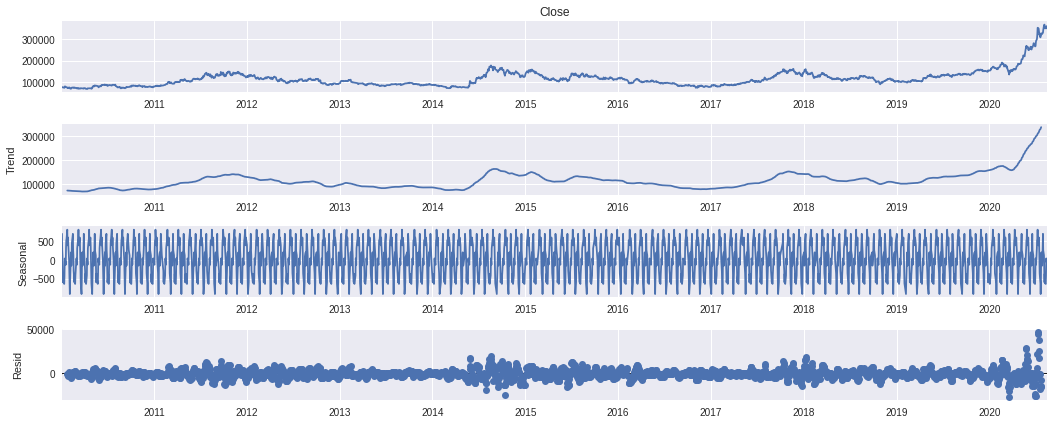

In [11]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,6)

In [12]:
kakao_price_log = np.log(kakao_price)

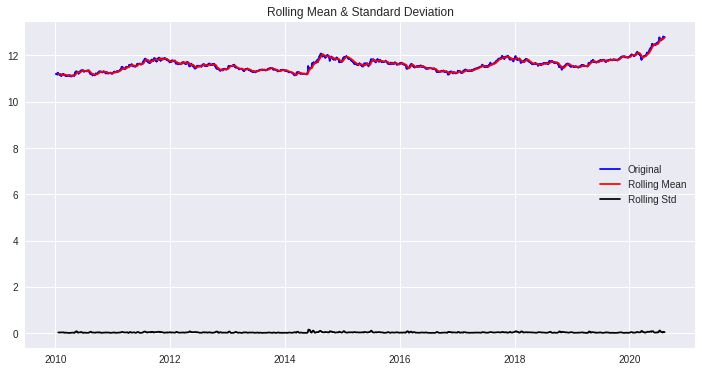

Results of Dickey-Fuller Test:
Test Statistic                   -0.120191
p-value                           0.947390
#Lags Used                        6.000000
Number of Observations Used    2614.000000
Critical Value (1%)              -3.432854
Critical Value (5%)              -2.862646
Critical Value (10%)             -2.567359
dtype: float64


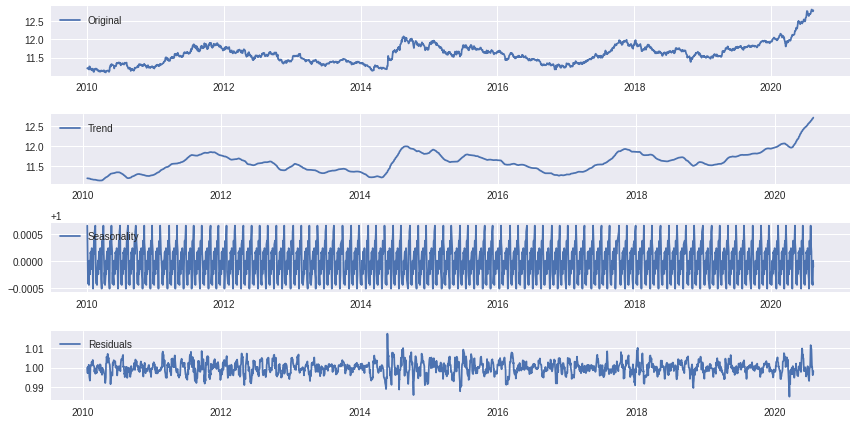

In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(kakao_price_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(kakao_price_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(kakao_price_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(kakao_price_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
# Residual 안정성
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.581001e+01
p-value                        1.049414e-28
#Lags Used                     1.900000e+01
Number of Observations Used    2.571000e+03
Critical Value (1%)           -3.432896e+00
Critical Value (5%)           -2.862665e+00
Critical Value (10%)          -2.567369e+00
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -21.943767
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2614.000000
Critical Value (1%)              -3.432854
Critical Value (5%)              -2.862646
Critical Value (10%)             -2.567359
dtype: float64


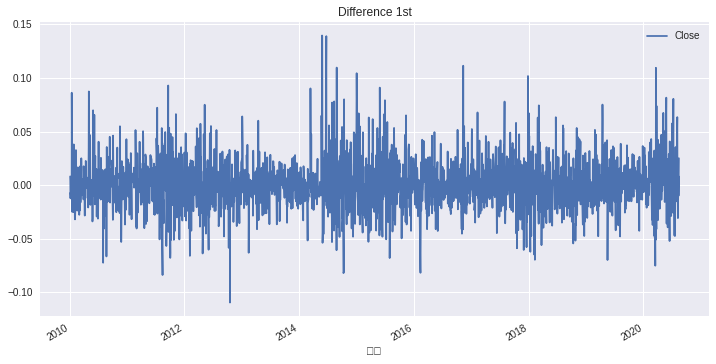

In [15]:
diff_1 = kakao_price_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.738628e+01
p-value                        5.039258e-30
#Lags Used                     2.800000e+01
Number of Observations Used    2.590000e+03
Critical Value (1%)           -3.432877e+00
Critical Value (5%)           -2.862657e+00
Critical Value (10%)          -2.567364e+00
dtype: float64


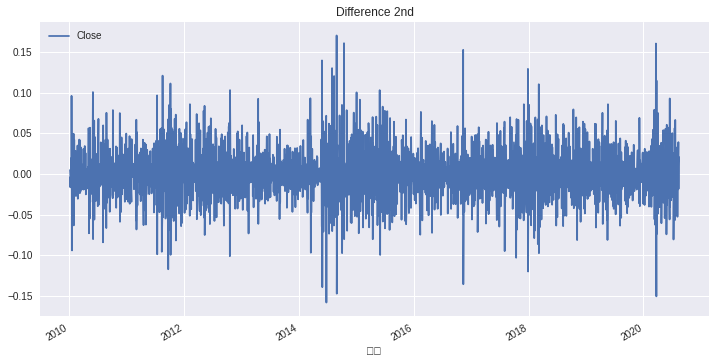

In [16]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

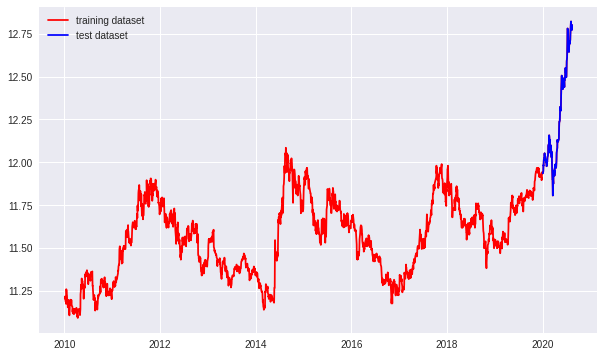

In [17]:
train_data, test_data = kakao_price_log.loc[:'2019-12-30'], kakao_price_log.loc['2020-01-02':]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kakao_price_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

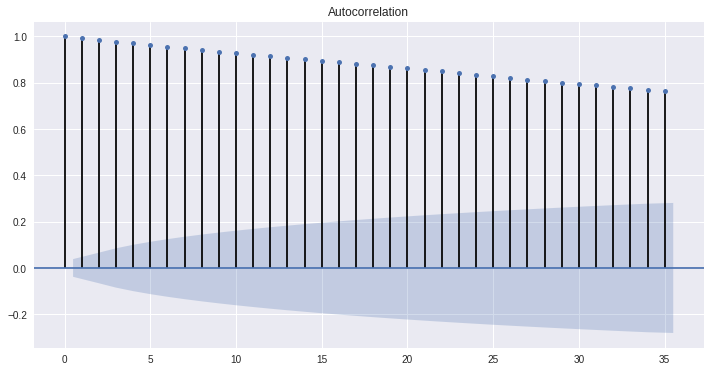

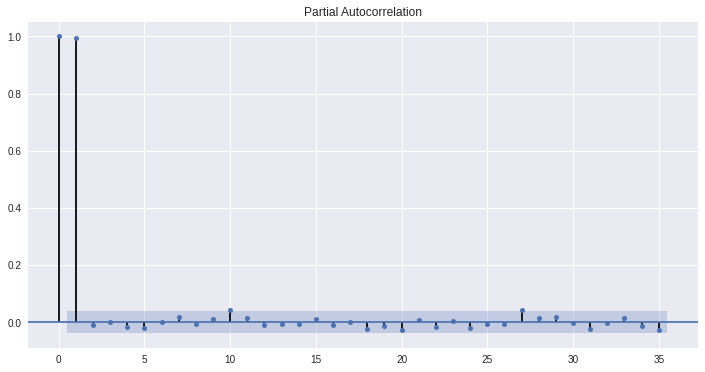

In [18]:
plot_acf(kakao_price_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(kakao_price_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [19]:
# model 생성 및 요약
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 2464
Model:                 ARIMA(1, 2, 0)   Log Likelihood                5312.416
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 13 Aug 2020   AIC                         -10618.831
Time:                        17:14:22   BIC                         -10601.402
Sample:                             2   HQIC                        -10612.499
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.961e-06      0.000      0.005      0.996      -0.001       0.001
ar.L1.D2.Close    -0.4704      0.018    -26.464      0.000      -0.505      -0.436
                                    

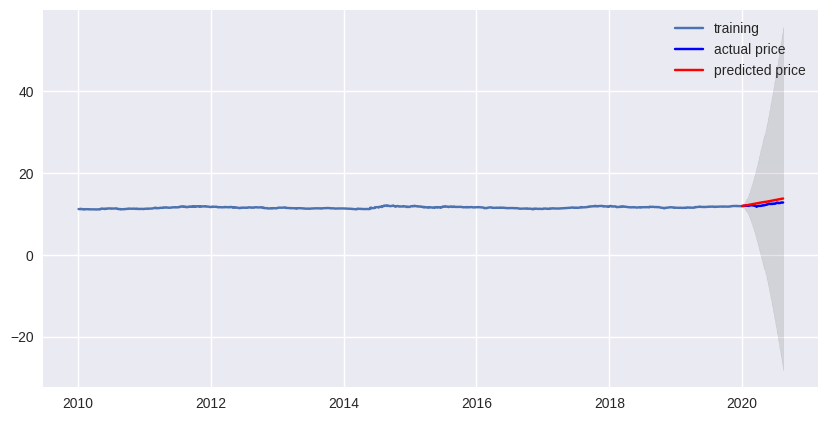

In [20]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [21]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
# print('MAPE: {:.2f}%'.format(mape*100))

MSE:  75254857763.24663
MAE:  219829.52216672196
RMSE:  274326.1886208581


# 더 좋은 pdq 찾기

In [22]:
# itertools 활용
p = list(range(2,5))
d = [2]
q = range(0,5)

In [23]:
# grid search
pdq_list = product(p,d,q)

In [24]:
AIC_list = []
for i in pdq_list:
    model = ARIMA(train_data, order=i)
    result = model.fit()
    AIC_list.append(result.aic)
    print('ARIMA{} - AIC{}'.format(i, result.aic))
print(AIC_list.index(min(AIC_list)))

ARIMA(2, 2, 0) - AIC-10934.968824518994
ARIMA(2, 2, 1) - AIC-11614.429790070059
ARIMA(2, 2, 2) - AIC-11617.765408953066
ARIMA(2, 2, 3) - AIC-11626.339452744902
ARIMA(2, 2, 4) - AIC-11623.878788495098
ARIMA(3, 2, 0) - AIC-11129.065886554337
ARIMA(3, 2, 1) - AIC-11620.300269672825
ARIMA(3, 2, 2) - AIC-11613.744949120704
ARIMA(3, 2, 3) - AIC-11623.86809936701
ARIMA(3, 2, 4) - AIC-11623.228014929562
ARIMA(4, 2, 0) - AIC-11179.865544009444
ARIMA(4, 2, 1) - AIC-11613.367125860314
ARIMA(4, 2, 2) - AIC-11614.615210155127
ARIMA(4, 2, 3) - AIC-11618.030682685174
ARIMA(4, 2, 4) - AIC-11618.414392315248
3


In [26]:
model = ARIMA(train_data, order=(2, 2, 2))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 2464
Model:                 ARIMA(2, 2, 2)   Log Likelihood                5814.883
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -11617.765
Time:                        17:14:36   BIC                         -11582.908
Sample:                             2   HQIC                        -11605.101
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.135e-07   2.91e-06      0.073      0.942   -5.49e-06    5.92e-06
ar.L1.D2.Close    -0.5981      0.779     -0.768      0.442      -2.124       0.928
ar.L2.D2.Close     0.0029      0.067

# 예측

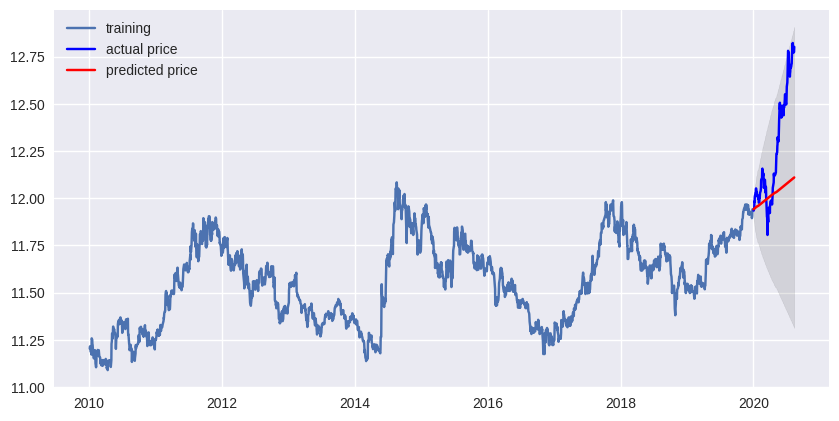

In [27]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [28]:
# mape 구하기
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mape = mean_absolute_percentage_error(np.exp(test_data), np.exp(fc))

In [30]:
mape

22.50028693198184